##Import various python functions and modules that we need.

In [1]:
from pandas import DataFrame
from IPython.display import FileLink

##Pylab namespace and inline plots. Import Rmagic.

In [2]:
%matplotlib inline
%load_ext rpy2.ipython

##Import R libraries we'll use.

In [3]:
%%R
library(phyloseq)
library(ggplot2)
library(foreach)
library(doParallel)
library(gridExtra)
library(dplyr)

foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com
Loading required package: iterators
Loading required package: parallel
Loading required package: grid

Attaching package: ‘dplyr’

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



##Import data for all treatment samples (fractions only). Get rid of OTUs not observed in at least 25% of samples)

###These files are from the [binning notebook](./OTU_binning.ipynb), [tree notebook](./Tree.ipynb), [merge mappers notebook](./Merge_mappers.ipynb) 

In [4]:
%%R
physeq = import_biom("/var/seq_data/priming_exp/data/otu_table.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.PE = prune_samples((physeq.md$Bulk == 0), physeq)
physeq.PE.snorm = transform_sample_counts(physeq.PE, function(x) x/sum(x))
physeq.PE.thresh = filter_taxa(physeq.PE.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.PE.thresh)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3203 taxa and 395 samples ]
sample_data() Sample Data:       [ 395 samples by 13 sample variables ]
phy_tree()    Phylogenetic Tree: [ 3203 tips and 3202 internal nodes ]


In [5]:
%%R
print(colnames(physeq.md))

 [1] "Sample"       "FractionNum"  "Bulk"         "Control"      "CC"          
 [6] "X100"         "X700"         "H2O"          "Day"          "Density"     
[11] "rep"          "contolVlabel" "Treatment"   


###Calculate pairwise weighted unifrac distances between samples.

In [6]:
%%R
registerDoParallel(cores=20)
wunif.dist = distance(physeq.PE.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

###Ordinate using weighted unifrac distances with NMDS.

In [7]:
%%R
nmds = ordinate(physeq.PE.thresh, 
                method = "NMDS", 
                distance = wunif.dist)

Run 0 stress 0.08445914 
Run 1 stress 0.1021289 
Run 2 stress 0.09431964 
Run 3 stress 0.08464928 
... procrustes: rmse 0.002151994  max resid 0.03111573 
Run 4 stress 0.08645271 
Run 5 stress 0.1181609 
Run 6 stress 0.09370044 
Run 7 stress 0.0881555 
Run 8 stress 0.1036801 
Run 9 stress 0.09407972 
Run 10 stress 0.08773268 
Run 11 stress 0.09201736 
Run 12 stress 0.09725773 
Run 13 stress 0.08439075 
... New best solution
... procrustes: rmse 0.002082679  max resid 0.04065931 
Run 14 stress 0.08697677 
Run 15 stress 0.09940589 
Run 16 stress 0.09013978 
Run 17 stress 0.08550089 
Run 18 stress 0.08690824 
Run 19 stress 0.09516313 
Run 20 stress 0.08626481 


In [8]:
%%R
df = plot_ordination(physeq.PE.thresh, nmds, justDF = TRUE)
df$Density = as.numeric(as.character(df$Density))

df.filt = df %>%
    filter(Sample != c("13C.700.45.03.21", "12C.000.28.03.27"))
head(df.filt)

        NMDS1        NMDS2           Sample FractionNum Bulk Control CC X100
1 -0.07650034 -0.009094490 12C.700.45.01.24          24    0       1  0    0
2  0.06309711 -0.072588234 12C.700.14.06.14          14    0       1  0    0
3  0.04170673 -0.013850707 12C.100.14.05.18          18    0       1  0    1
4  0.03500981 -0.006014293 12C.700.14.06.05           5    0       1  0    0
5 -0.19155307 -0.012315973 12C.000.14.05.18          18    0       1  1    0
6  0.04667323 -0.032921572 12C.100.14.05.11          11    0       1  0    1
  X700 H2O Day Density rep contolVlabel Treatment
1    1   0  45  1.6783          control    12C700
2    1   0  14  1.7122          control    12C700
3    0   0  14  1.6980          control    12C100
4    1   0  14  1.7559          control    12C700
5    0   0  14  1.6936          control    12C000
6    0   0  14  1.7253          control    12C100


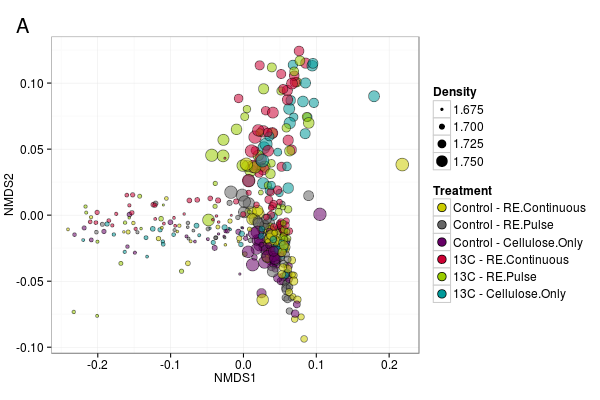

In [9]:
%%R -w 600 -h 400 

colours = c("#660066", "#CCCC00", "#666666", "#009999", "#CC0033", "#99CC00")

p1 = ggplot(df.filt, aes(x = NMDS1, y = NMDS2)) 

p1 = p1 + geom_point(aes(fill = Treatment, size = Density, alpha = 0.85), shape=21) 

p1 = p1 + scale_fill_manual(values = colours,
                            breaks=c("12C100", "12C700", "12C000", "13C100", "13C700", "13C000"),
                            labels=c("Control - RE.Continuous", "Control - RE.Pulse", "Control - Cellulose.Only",
                                     "13C - RE.Continuous", "13C - RE.Pulse", "13C - Cellulose.Only"))

p1 = p1 + guides(alpha = FALSE)

p1 = p1 + scale_size_area(aesthetics = "Density")

p1 = p1 + ggtitle("A")

p1 = p1 + guides(fill = guide_legend(override.aes = list(size = 4)))
p1 = p1 + guides(size = guide_legend(override.aes = list(fill = "black")))

p1 = p1 + theme_bw()
p1 = p1 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p1 = p1 + theme(plot.title = element_text(hjust = -0.1, size = 20),
                axis.text = element_text(size = 12),
                axis.title = element_text(size = 12),
                legend.text = element_text(size = 12),
                legend.title = element_text(size = 12))

p1

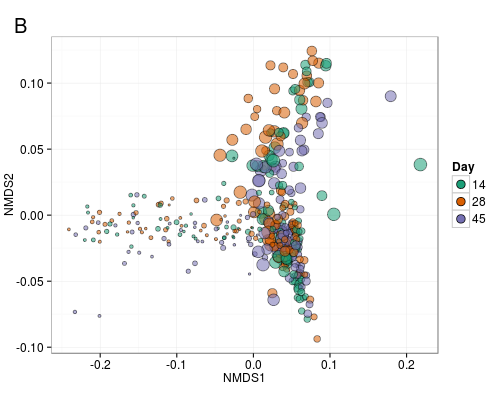

In [10]:
%%R -w 500 -h 400

p2 = ggplot(df.filt, aes(x = NMDS1, y = NMDS2))

p2 = p2 + geom_point(aes(fill = factor(Day), size = Density, alpha = 0.85), shape=21)

p2 = p2 + scale_fill_brewer(palette="Dark2")

p2 = p2 + guides(alpha = FALSE, size = FALSE)

p2 = p2 + scale_size_area(aesthetics = "Density")

p2 = p2 + ggtitle("B")

p2 = p2 + guides(fill = guide_legend(title = "Day", override.aes = list(size = 4)))

p2 = p2 + theme_bw()
p2 = p2 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p2 = p2 + theme(plot.title = element_text(hjust = -0.1, size = 20),
                axis.text = element_text(size = 12),
                axis.title = element_text(size = 12),
                legend.text = element_text(size = 12),
                legend.title = element_text(size = 12))

p2

##Import data for cellulose only treatment samples (fractions only). Get rid of OTUs not observed in at least 25% of samples)

In [11]:
%%R
physeq.md = sample_data(physeq)
physeq.PE2 = prune_samples((physeq.md$Bulk == 0)&
                          (!(physeq.md$Sample %in% c("13C.700.45.03.21", "12C.000.28.03.27")))&
                          (physeq.md$Treatment %in% c("12C000","13C000")), physeq)
physeq.PE2.snorm = transform_sample_counts(physeq.PE2, function(x) x/sum(x))
physeq.PE2.thresh = filter_taxa(physeq.PE2.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.PE2.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3279 taxa and 127 samples ]
sample_data() Sample Data:       [ 127 samples by 13 sample variables ]
phy_tree()    Phylogenetic Tree: [ 3279 tips and 3278 internal nodes ]


In [12]:
%%R
registerDoParallel(cores=20)
wunif.dist2 = distance(physeq.PE2.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [13]:
%%R
nmds2 = ordinate(physeq.PE2.thresh, 
                method = "NMDS", 
                distance = wunif.dist2)

Run 0 stress 0.0764548 
Run 1 stress 0.07830764 
Run 2 stress 0.07645548 
... procrustes: rmse 0.0003633969  max resid 0.003300219 
*** Solution reached


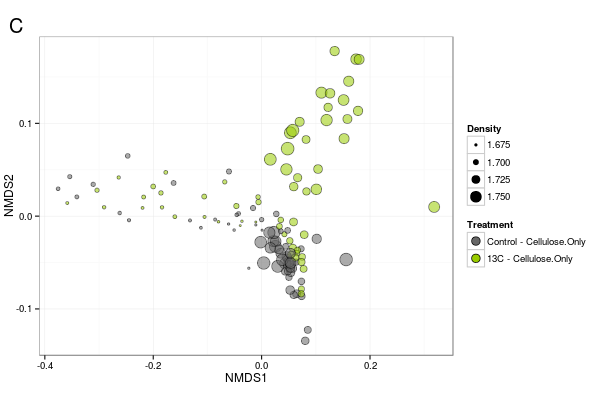

In [14]:
%%R -w 600 -h 400

colours = c("#666666", "#99CC00", "#ff7f00", "#377eb8", "#4daf4a", "#00f5ff", "#ff4040", "#68228b")

df2 = plot_ordination(physeq.PE2.thresh, nmds2, justDF = TRUE)
df2$Density = as.numeric(as.character(df2$Density))

p3 = ggplot(df2, aes(x = NMDS1, y = NMDS2)) 
p3 = p3 + geom_point(aes(fill = Treatment, size = Density, alpha = 0.85), shape=21) 
p3 = p3 + scale_fill_manual(values = colours,
                            breaks=c("12C000", "13C000"),
                            labels=c("Control - Cellulose.Only", "13C - Cellulose.Only"))
p3 = p3 + guides(alpha = FALSE)
p3 = p3 + scale_size_area(aesthetics = "Density")
p3 = p3 + ggtitle("C")
p3 = p3 + guides(fill = guide_legend(override.aes = list(size = 4)))
p3 = p3 + guides(size = guide_legend(override.aes = list(fill = "black")))
p3 = p3 + theme_bw()
p3 = p3 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p3 = p3 + theme(plot.title = element_text(hjust = -0.075, size = 20))

p3

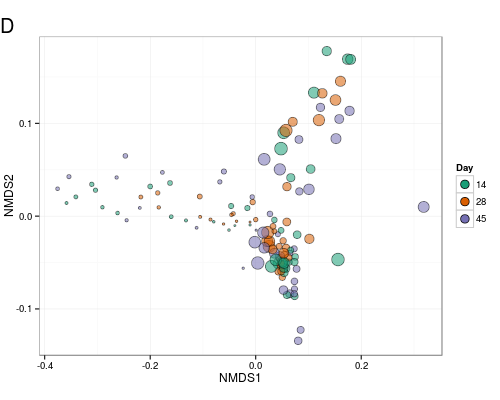

In [15]:
%%R -w 500 -h 400

p4 = ggplot(df2, aes(x = NMDS1, y = NMDS2))
p4 = p4 + geom_point(aes(fill = factor(Day), size = Density, alpha = 0.85), shape=21)
p4 = p4 + scale_fill_brewer(palette="Dark2")
p4 = p4 + guides(alpha = FALSE, size = FALSE)
p4 = p4 + scale_size_area(aesthetics = "Density")
p4 = p4 + ggtitle("D")
p4 = p4 + guides(fill = guide_legend(title = "Day", override.aes = list(size = 4)))
p4 = p4 + theme_bw()
p4 = p4 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p4 = p4 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p4

##Import data for RE.pulse treatment samples (fractions only). Get rid of OTUs not observed in at least 25% of samples)

In [16]:
%%R
physeq = import_biom("/var/seq_data/priming_exp/data/otu_table.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.PE3 = prune_samples((physeq.md$Bulk == 0)& 
                          (!(physeq.md$Sample %in% c("13C.700.45.03.21", "12C.000.28.03.27")))&
                          (physeq.md$Treatment %in% c("12C700","13C700")), physeq)
physeq.PE3.snorm = transform_sample_counts(physeq.PE3, function(x) x/sum(x))
physeq.PE3.thresh = filter_taxa(physeq.PE3.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.PE3.thresh)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3323 taxa and 121 samples ]
sample_data() Sample Data:       [ 121 samples by 13 sample variables ]
phy_tree()    Phylogenetic Tree: [ 3323 tips and 3322 internal nodes ]


In [17]:
%%R
registerDoParallel(cores=20)
wunif.dist3 = distance(physeq.PE3.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [18]:
%%R
nmds3 = ordinate(physeq.PE3.thresh, 
                method = "NMDS", 
                distance = wunif.dist3)

Run 0 stress 0.08740728 
Run 1 stress 0.09740235 
Run 2 stress 0.1231944 
Run 3 stress 0.1511365 
Run 4 stress 0.142029 
Run 5 stress 0.1543739 
Run 6 stress 0.115819 
Run 7 stress 0.153366 
Run 8 stress 0.08740705 
... New best solution
... procrustes: rmse 5.314092e-05  max resid 0.0004690346 
*** Solution reached


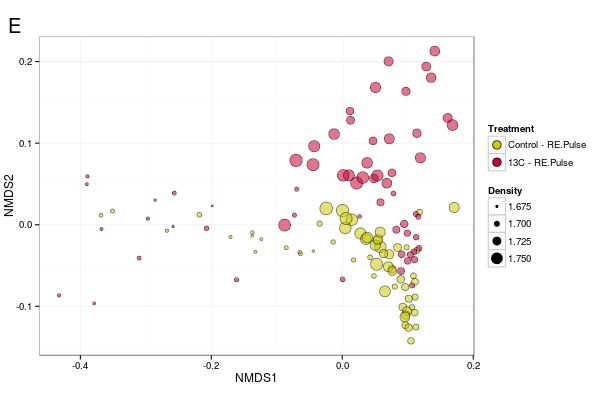

In [19]:
%%R -w 600 -h 400

colours = c("#CCCC00", "#CC0033", "#ff7f00", "#377eb8", "#4daf4a", "#00f5ff", "#ff4040", "#68228b")

df3 = plot_ordination(physeq.PE3.thresh, nmds3, justDF = TRUE)
df3$Density = as.numeric(as.character(df3$Density))

p5 = ggplot(df3, aes(x = NMDS1, y = NMDS2)) 
p5 = p5 + geom_point(aes(fill = Treatment, size = Density, alpha = 0.85), shape=21) 
p5 = p5 + scale_fill_manual(values = colours,
                            breaks=c("12C700", "13C700"),
                            labels=c("Control - RE.Pulse","13C - RE.Pulse"))
p5 = p5 + guides(alpha = FALSE)
p5 = p5 + scale_size_area(aesthetics = "Density")
p5 = p5 + ggtitle("E")
p5 = p5 + guides(fill = guide_legend(override.aes = list(size = 4)))
p5 = p5 + guides(size = guide_legend(override.aes = list(fill = "black")))
p5 = p5 + theme_bw()
p5 = p5 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p5 = p5 + theme(plot.title = element_text(hjust = -0.075, size = 20))
p5

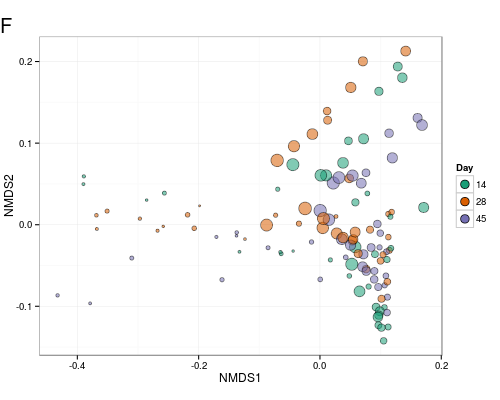

In [20]:
%%R -w 500 -h 400

p6 = ggplot(df3, aes(x = NMDS1, y = NMDS2))
p6 = p6 + geom_point(aes(fill = factor(Day), size = Density, alpha = 0.85), shape=21)
p6 = p6 + scale_fill_brewer(palette="Dark2")
p6 = p6 + guides(alpha = FALSE, size = FALSE)
p6 = p6 + scale_size_area(aesthetics = "Density")
p6 = p6 + ggtitle("F")
p6 = p6 + guides(fill = guide_legend(title = "Day", override.aes = list(size = 4)))
p6 = p6 + theme_bw()
p6 = p6 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p6 = p6 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p6

##Import data for RE.continuous treatment samples (fractions only). Get rid of OTUs not observed in at least 25% of samples)

In [21]:
%%R
physeq = import_biom("/var/seq_data/priming_exp/data/otu_table.biom", "/var/seq_data/priming_exp/data/otusn.tree")
sample.data = import_qiime_sample_data("/var/seq_data/priming_exp/data/allsample_metadata_nomock.txt")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.PE4 = prune_samples((physeq.md$Bulk == 0)& (physeq.md$Treatment %in% c("12C100","13C100")), physeq)
physeq.PE4.snorm = transform_sample_counts(physeq.PE4, function(x) x/sum(x))
physeq.PE4.thresh = filter_taxa(physeq.PE4.snorm, function(x) sum(x > 0) > (0.25 * length(x)), TRUE)
print(physeq.PE4.thresh)


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3027 taxa and 145 samples ]
sample_data() Sample Data:       [ 145 samples by 13 sample variables ]
phy_tree()    Phylogenetic Tree: [ 3027 tips and 3026 internal nodes ]


In [22]:
%%R
registerDoParallel(cores=20)
wunif.dist4 = distance(physeq.PE4.thresh, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)

In [23]:
%%R
nmds4 = ordinate(physeq.PE4.thresh, 
                method = "NMDS", 
                distance = wunif.dist4)

Run 0 stress 0.08243435 
Run 1 stress 0.08254468 
... procrustes: rmse 0.003720704  max resid 0.04267688 
Run 2 stress 0.08386604 
Run 3 stress 0.0837369 
Run 4 stress 0.4148653 
Run 5 stress 0.08258359 
... procrustes: rmse 0.002751725  max resid 0.01790464 
Run 6 stress 0.08301915 
Run 7 stress 0.1038306 
Run 8 stress 0.1370576 
Run 9 stress 0.08442608 
Run 10 stress 0.08237854 
... New best solution
... procrustes: rmse 0.00692069  max resid 0.06854381 
Run 11 stress 0.08430586 
Run 12 stress 0.08296121 
Run 13 stress 0.08295867 
Run 14 stress 0.08385715 
Run 15 stress 0.08375633 
Run 16 stress 0.08302479 
Run 17 stress 0.08373556 
Run 18 stress 0.1276535 
Run 19 stress 0.08390277 
Run 20 stress 0.08227167 
... New best solution
... procrustes: rmse 0.003643873  max resid 0.0423606 


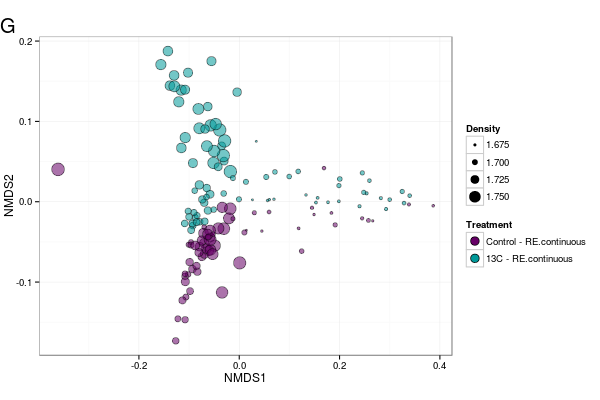

In [24]:
%%R -w 600 -h 400

colours = c("#660066", "#009999", "#ff7f00", "#377eb8", "#4daf4a", "#00f5ff", "#ff4040", "#68228b")

df4 = plot_ordination(physeq.PE4.thresh, nmds4, justDF = TRUE)
df4$Density = as.numeric(as.character(df4$Density))

p7 = ggplot(df4, aes(x = NMDS1, y = NMDS2)) 
p7 = p7 + geom_point(aes(fill = Treatment, size = Density, alpha = 0.85), shape=21) 
p7 = p7 + scale_fill_manual(values = colours,
                            breaks=c("12C100", "13C100"),
                            labels=c("Control - RE.continuous", "13C - RE.continuous"))
p7 = p7 + guides(alpha = FALSE)
p7 = p7 + scale_size_area(aesthetics = "Density")
p7 = p7 + ggtitle("G")
p7 = p7 + guides(fill = guide_legend(override.aes = list(size = 4)))
p7 = p7 + guides(size = guide_legend(override.aes = list(fill = "black")))
p7 = p7 + theme_bw()
p7 = p7 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p7 = p7 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p7

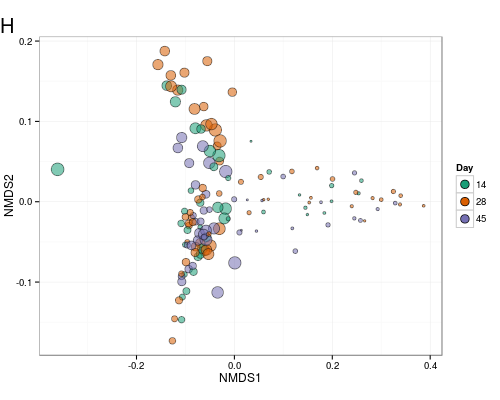

In [25]:
%%R -w 500 -h 400

p8 = ggplot(df4, aes(x = NMDS1, y = NMDS2))
p8 = p8 + geom_point(aes(fill = factor(Day), size = Density, alpha = 0.85), shape=21)
p8 = p8 + scale_fill_brewer(palette="Dark2")
p8 = p8 + guides(alpha = FALSE, size = FALSE)
p8 = p8 + scale_size_area(aesthetics = "Density")
p8 = p8 + ggtitle("H")
p8 = p8 + guides(fill = guide_legend(title = "Day", override.aes = list(size = 4)))
p8 = p8 + theme_bw()
p8 = p8 + theme(plot.margin = unit(c(1,0,1,0), "lines"))
p8 = p8 + theme(plot.title = element_text(hjust = -0.1, size = 20))

p8

NULL


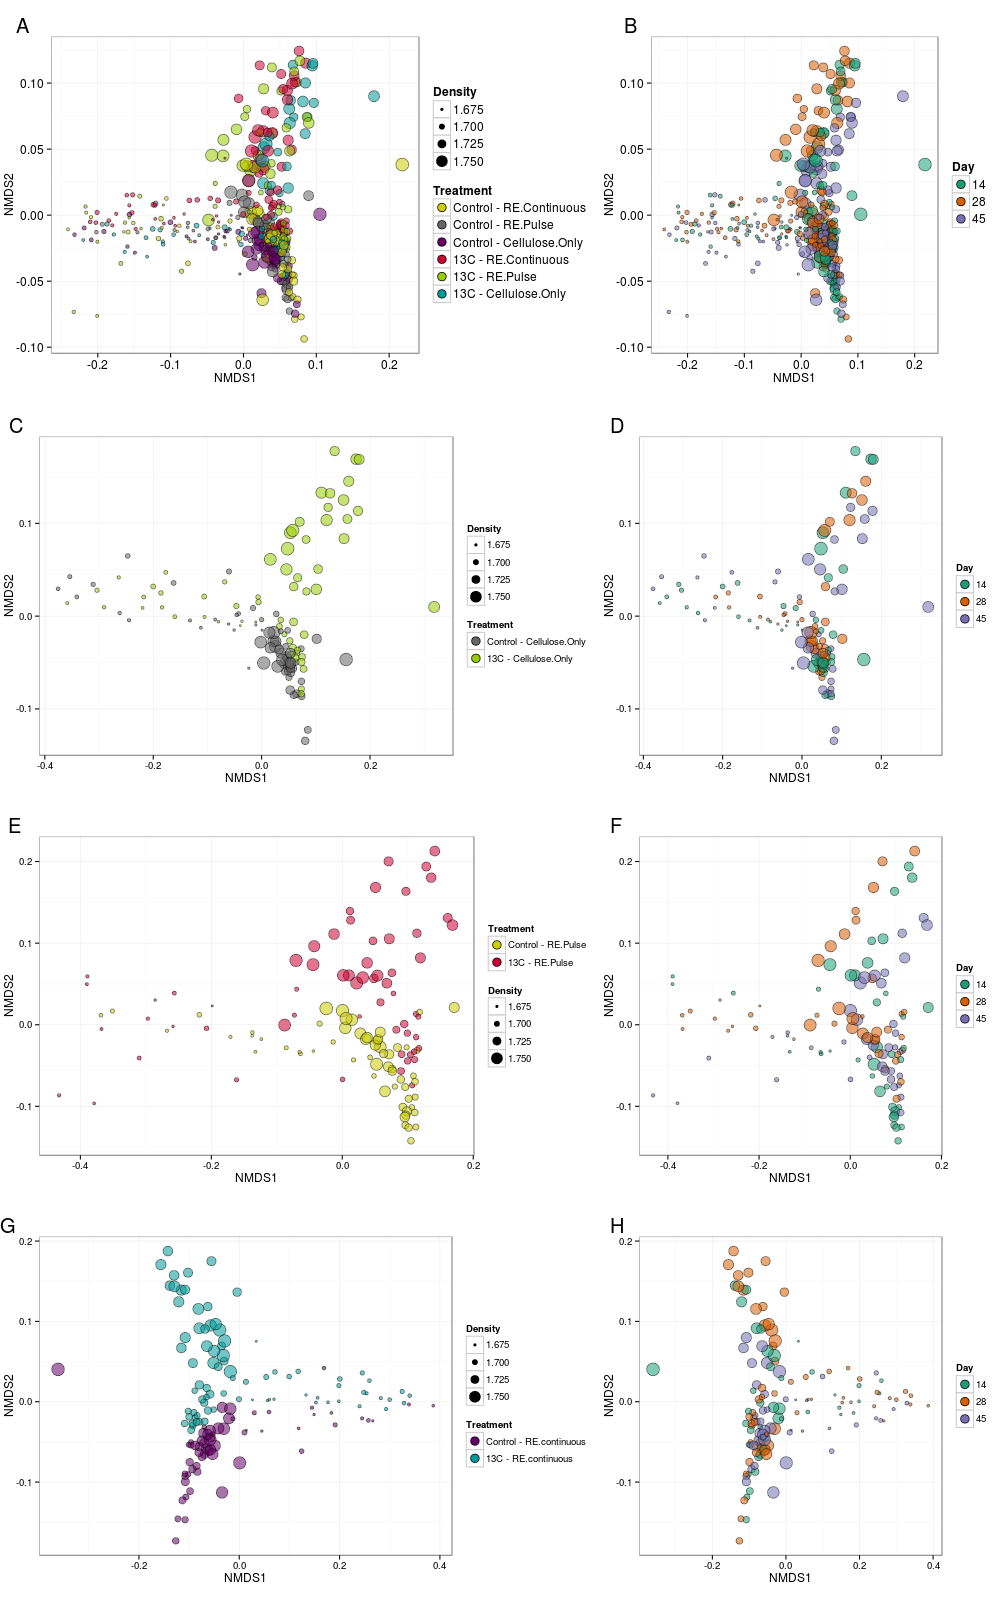

In [26]:
%%R -w 1000 -h 1600
p.combined = grid.arrange(p1, p2, p3,
                           p4, p5, p6,
                           p7, p8, 
                           widths = c(1.5,1), heights = c(1,1), 
                           ncol = 2)

p.combined

In [27]:
%%R -w 1000 -h 1000
pdf("figs/Ordination_8panel.pdf", width = 11, height = 15)
grid.arrange(p1, p2, p3,
             p4, p5, p6,
             p7, p8, 
             widths = c(1.3,1), heights = c(1,1), 
             ncol = 2)
dev.off()

png 
  2 


In [28]:
FileLink("figs/Ordination_8panel.pdf")

/home/ashley/priming_exp/figs/Ordination_8panel.pdf

In [29]:
%%R 
png("figs/Ordination_8panel.png", width = 11, height = 15, units = "in", res = 600)
grid.arrange(p1, p2, p3,
             p4, p5, p6,
             p7, p8, 
             widths = c(1.5,1), heights = c(1,1), 
             ncol = 2)
dev.off()

png 
  2 


In [30]:
FileLink("figs/Ordination_8panel.png")

/home/ashley/priming_exp/figs/Ordination_8panel.png